# Feature analysis
In this notebook we compare similarity between original/augmented images with running statistics, accumulated during network training.

## Initialization

In [1]:
import sys
import os
import warnings
import math
from tqdm import tqdm
sys.path.append(os.getcwd())
sys.path.append("..")
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib as mpl
import matplotlib.pyplot as plt

from recognition.models.iresnet_custom import iresnet200
from utils import *
from augmentations import *
from bn_extraction.models.kld_extractor import KLDExtractor
from bn_extraction.utils import *

device = "cpu"

In [2]:
#Load datasets with black-skinned human, white-skinned human and animals.

from torchvision.datasets import ImageFolder
black_ds = SimpleDataset('./test_images/african')
white_ds = SimpleDataset("./test_images/glint_white")
animal_ds = SimpleDataset('./test_images/pets')

orig_image = white_ds[0]

#### Load network

As similarity metric we use symmetric Kullback–Leibler divergence,   
so we need to calculate KLD between every channel of every BN. You can use KLDExtractor.

In [3]:
!wget -nc http://download.3divi.com/facesdk/archives/artifacts/ml/models/iresnet200_weigths.pth -O ../recognition/weights/iresnet200_weights.pth

File ‘../recognition/weights/iresnet200_weights.pth’ already there; not retrieving.


In [4]:
#Create face recognition model which extracts KLD between inputs and running vars at every BN layer.
backbone = iresnet200(conv_bias=True, disable_bn2_bn3=True).to(device)
backbone.load_state_dict(torch.load("../recognition/weights/iresnet200_weights.pth", map_location=device), strict=False)
_ = backbone.eval()

backbone_klde = KLDExtractor(backbone,device=device)
running_vals = get_running_vals(backbone)

#### Load normalization array

R200 was trained on WebFace42M (WF42). We took some images from WF42 and calculated KLD for all channels.   
Then we took 75th quantile of extracted KLDs to divide KLDs from glint by it.  
This makes easy to see which features have statistics higher then 75th quantile of the original dataset.

In [5]:
norm_arr = np.load("q75.npy")
id_starts, id_ends, masks = make_nonzero_running_vars_mask(running_vals)
id_starts = id_starts[:-1]
id_ends = id_ends[:-1]
masks = masks[:-1]

## Augmentations

We followed this steps:
1. Take an image and apply augmentations
2. Calculate KLD between running statistics (mean/var for every channel of BN) and mean/var for every channel of image when passing to this BN.
3. Divide KLD by normalization array(75th quantile of training dataset's KLD)
4. Plot mean for KLDs of every layer 

In [6]:
orig_image = white_ds.transform(
    cv2.cvtColor(
        cv2.imread(
            './test_images/glint_white/697135.jpg', 
            cv2.IMREAD_UNCHANGED), 
        cv2.COLOR_BGR2RGB)
)

#### Brightness

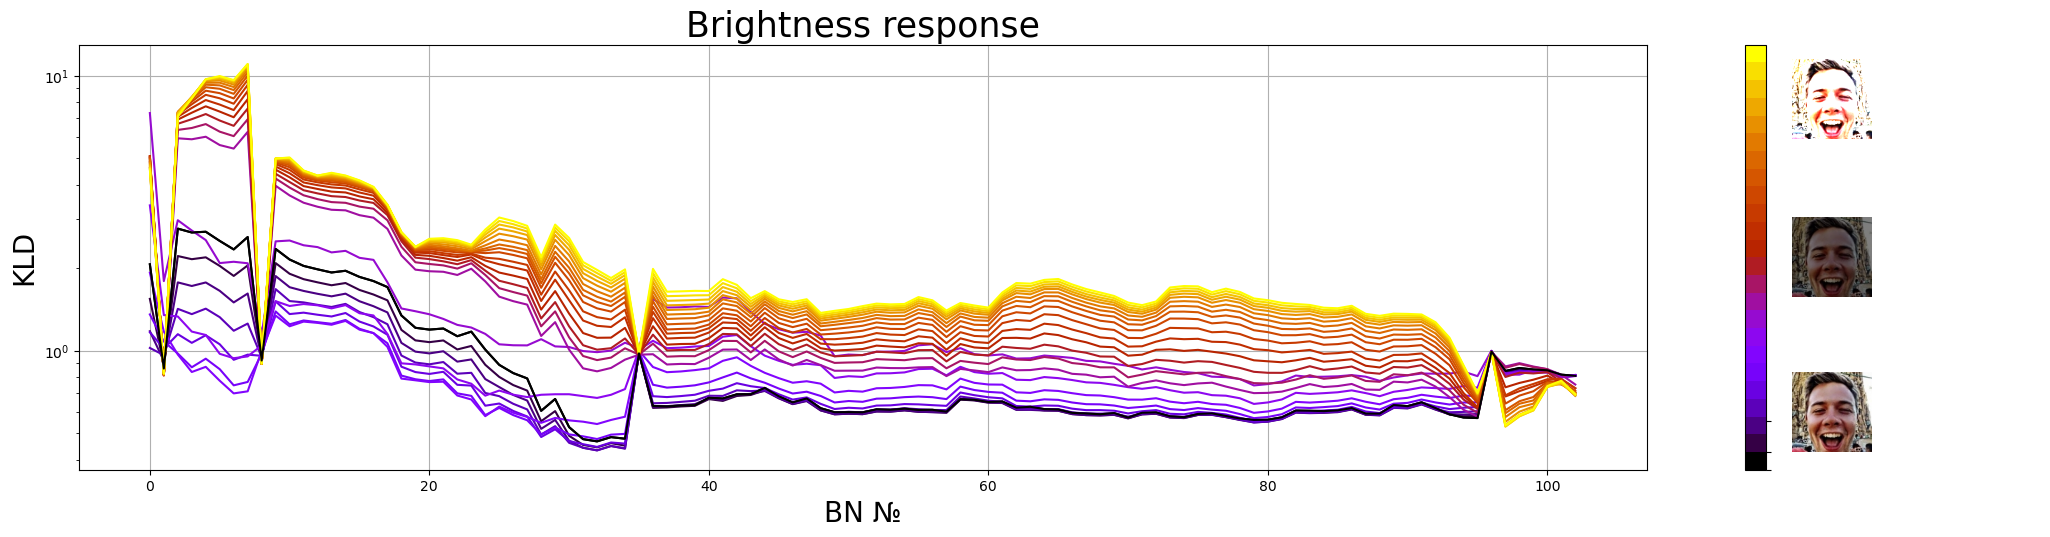

In [7]:
images_jutted_color = make_jutted_tensor(orig_image, )
images_statistic = backbone_klde(images_jutted_color)[1]
images_statistic /= norm_arr
feature_tensor = [images_statistic[:,id_s:id_e][:,mask] for id_s, id_e, mask in zip(id_starts, id_ends, masks)]
_feature_tensor = [t.mean(dim=1) for t in feature_tensor]


plot_augmented_features(
    images_jutted_color, 
    feature_tensor=torch.vstack(_feature_tensor).T, 
    feature_name='KLD', 
    clr_bar_range=(0.0, 24.6), 
    clr_bar_label="brightness", 
    color_map= 'gnuplot', 
    log_scale=True,
    title="Brightness response", 
)

#### Rotation

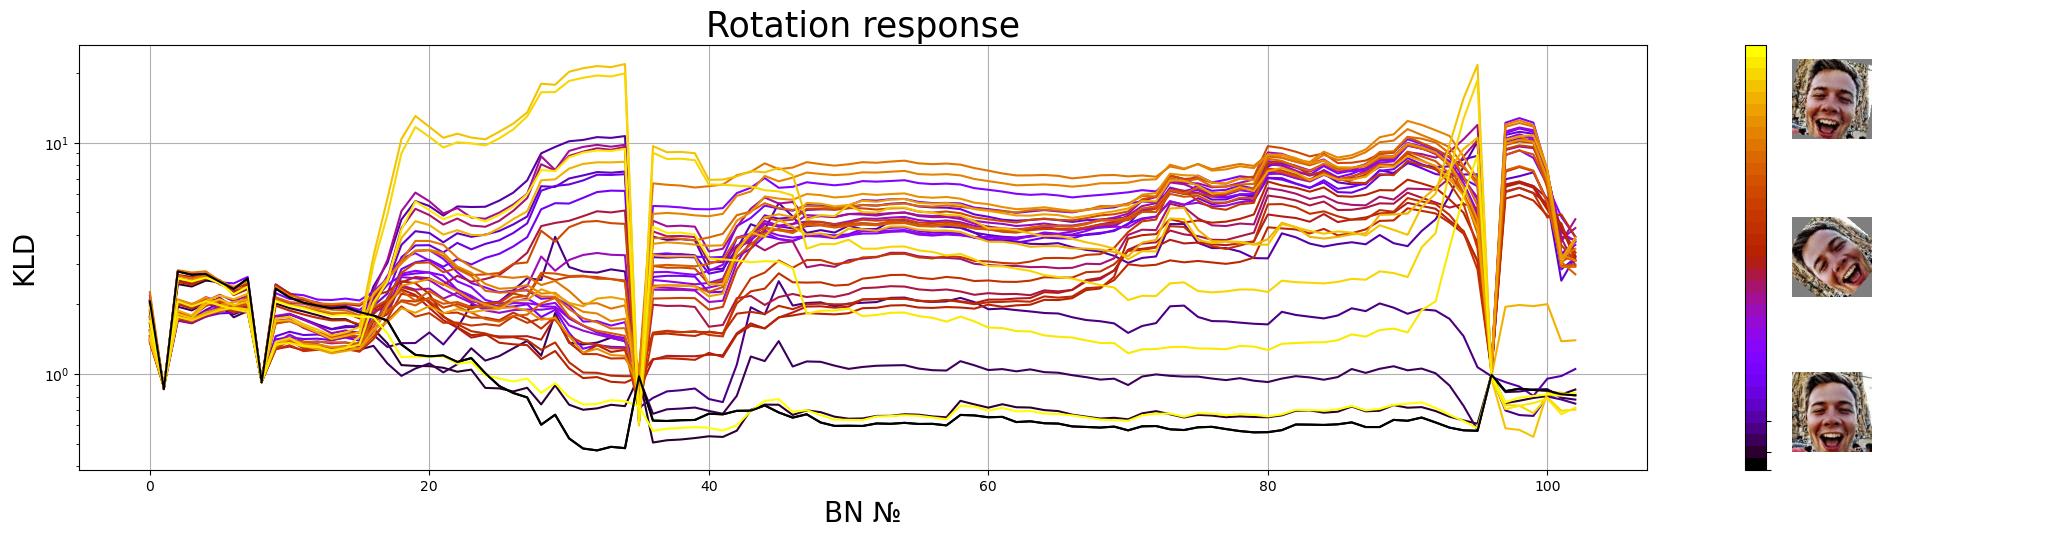

In [8]:
images_with_rotation = make_rotated_tensor(orig_image)
images_statistic = backbone_klde(images_with_rotation)[1]
images_statistic /= norm_arr
feature_tensor = [images_statistic[:,id_s:id_e][:,mask] for id_s, id_e, mask in zip(id_starts, id_ends, masks)]
_feature_tensor = [t.mean(dim=1) for t in feature_tensor]


plot_augmented_features(
    images_with_rotation, 
    feature_tensor=torch.vstack(_feature_tensor).T,
    feature_name='KLD', 
    clr_bar_range=(0.0, 24.6), 
    clr_bar_label="Rotation",
    color_map= 'gnuplot', 
    log_scale=True,
    title="Rotation response", 
)

#### Blur

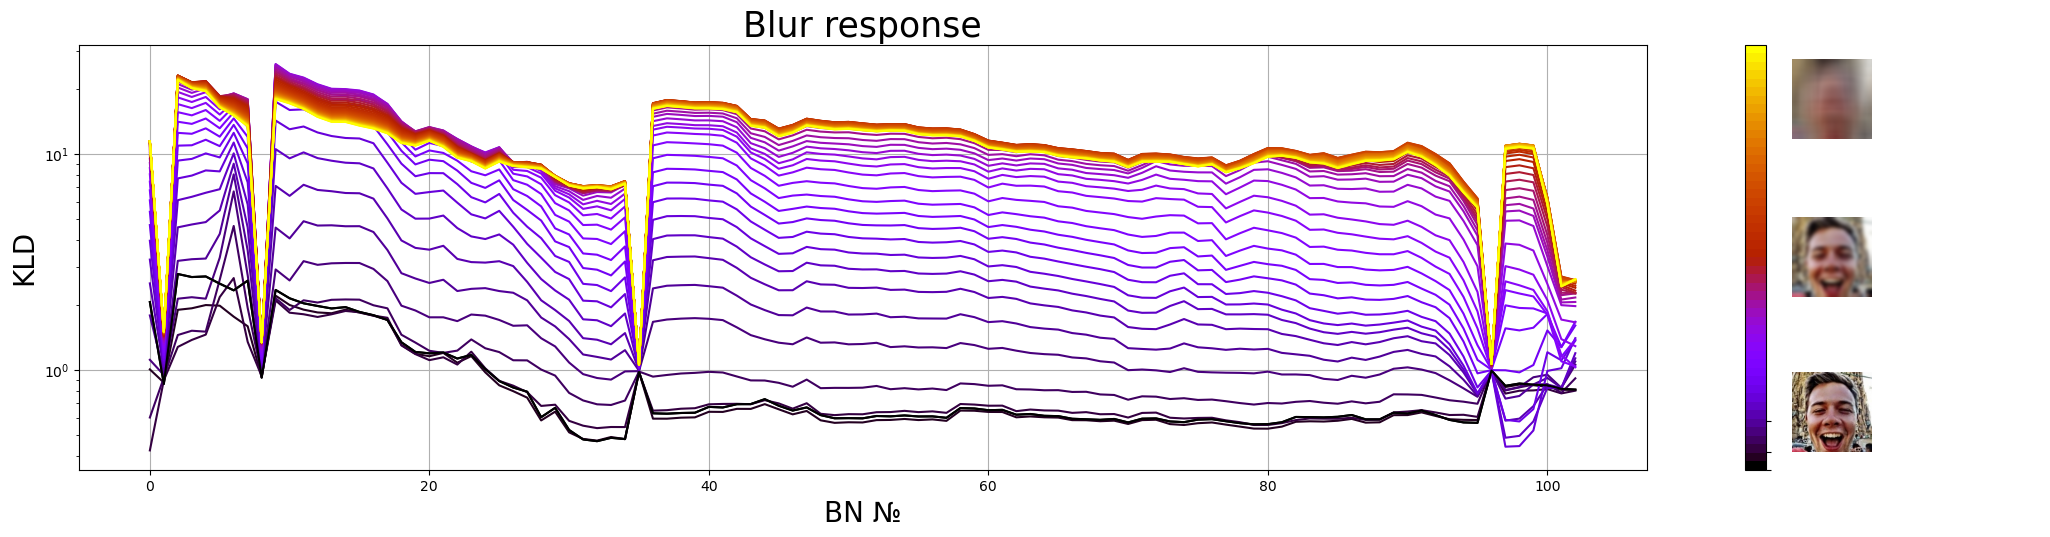

In [9]:
images_with_blur = make_blurred_tensor(orig_image)
images_statistic = backbone_klde(images_with_blur)[1]
images_statistic /= norm_arr
feature_tensor = [images_statistic[:,id_s:id_e][:,mask] for id_s, id_e, mask in zip(id_starts, id_ends, masks)]
_feature_tensor = [t.mean(dim=1) for t in feature_tensor]

plot_augmented_features(
    images_with_blur, 
    feature_tensor=torch.vstack(_feature_tensor).T, 
    feature_name='KLD', 
    clr_bar_range=(0.0, 24.6), 
    clr_bar_label="blur scale",
    color_map= 'gnuplot', 
    log_scale=True,
    title="Blur response", 
)

#### Apply grid

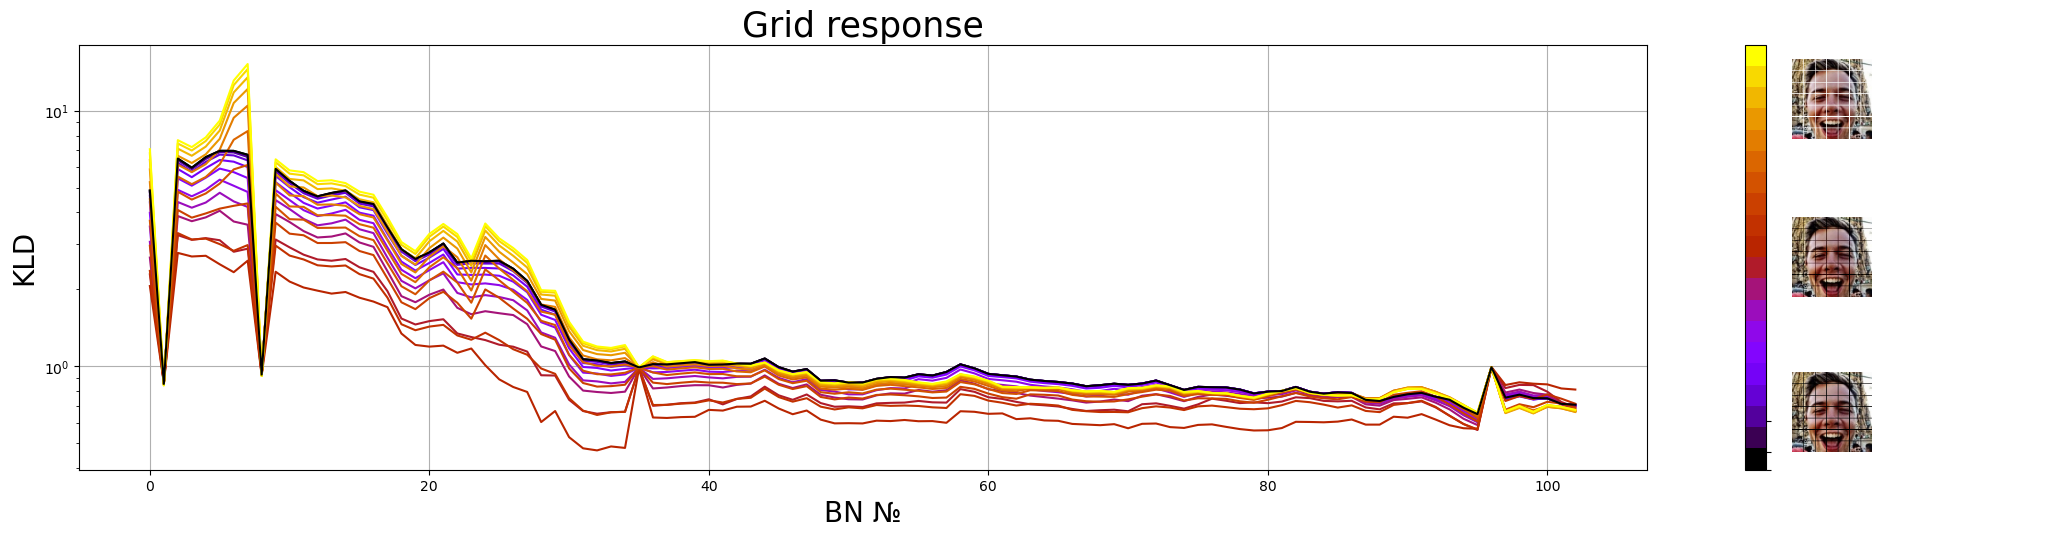

In [10]:
images_with_grid = make_grid_tensor(orig_image)
images_statistic = backbone_klde(images_with_grid)[1]
images_statistic /= norm_arr
feature_tensor = [images_statistic[:,id_s:id_e][:,mask] for id_s, id_e, mask in zip(id_starts, id_ends, masks)]
_feature_tensor = [t.mean(dim=1) for t in feature_tensor]


plot_augmented_features(
    images_with_grid, 
    feature_tensor=torch.vstack(_feature_tensor).T, 
    feature_name='KLD', 
    clr_bar_range=(0.0, 24.6), 
    clr_bar_label="blur scale",
    color_map= 'gnuplot', 
    log_scale=True,
    title="Grid response", 
)

### Distribution of statistics of different domains along the network

#### Datasets

We took images of black human, white human and animals. Humans were presented in the training dataset,  
so we expect the distribution of their statistics to have a low KLD with a training domain, unlike animals.

In [11]:
statistics = []
batch_size = 256
for ds in [black_ds, white_ds, animal_ds]:
    statistic = None
    loader = DataLoader(ds, batch_size=batch_size)
    it = iter(loader)
    for batch in tqdm(it):
        images_statistic = backbone_klde(batch)[1]
        images_statistic /= norm_arr
        feature_tensor = [images_statistic[:,id_s:id_e] for id_s, id_e, _ in zip(id_starts, id_ends, masks)]
        _feature_tensor = [t.mean(dim=1) for t in feature_tensor]
        if statistic is None:
            statistic = feature_tensor
        else:
            statistic = torch.vstack((statistic, feature_tensor))
    statistics.append(torch.hstack(statistic))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


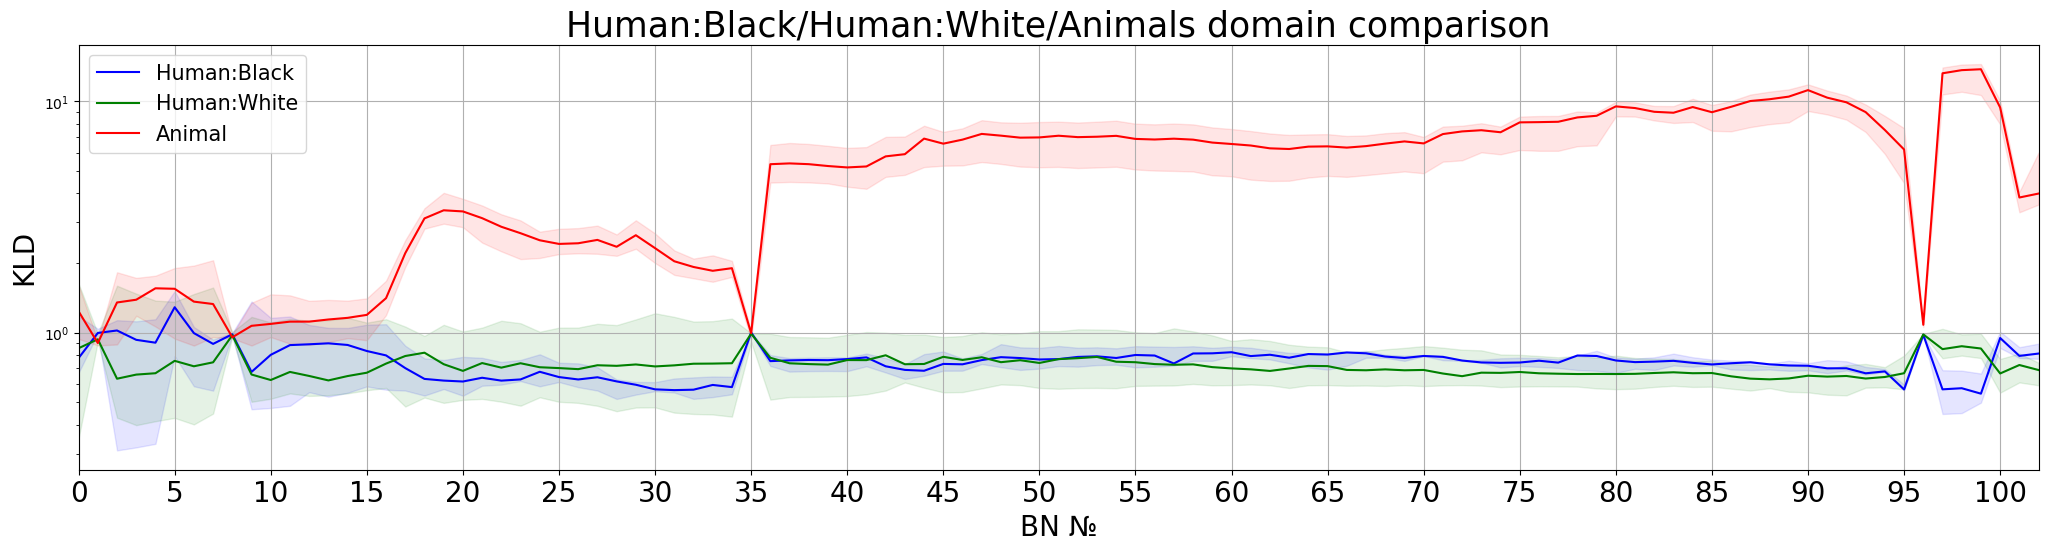

In [12]:
start_layer = 0
end_layer = 103
fig = plt.figure(figsize=(28,5))
ax1 = fig.add_axes([0.10,0.10,0.70,0.85])
plt.title(f"Human:Black/Human:White/Animals domain comparison" , fontsize = 25)
colors = ["blue","green","red"]
labels = ["Human:Black","Human:White", "Animal"]

for i, s in enumerate(statistics):
    s_q25 = torch.Tensor([np.quantile(s[:, id_s:id_e][:,mask].mean(1), q=0.25) for id_s, id_e, mask in zip(id_starts, id_ends, masks)])
    s_q50 = torch.Tensor([np.quantile(s[:, id_s:id_e][:,mask].mean(1), q=0.50) for id_s, id_e, mask in zip(id_starts, id_ends, masks)])
    s_q75 = torch.Tensor([np.quantile(s[:, id_s:id_e][:,mask].mean(1), q=0.75) for id_s, id_e, mask in zip(id_starts, id_ends, masks)])
    plt.plot(range(start_layer,end_layer),s_q50[start_layer:end_layer], color=colors[i], label=labels[i])
    plt.fill_between(range(start_layer,end_layer), s_q75[start_layer:end_layer], s_q25[start_layer:end_layer], alpha=0.1, color=colors[i])

plt.xlabel('BN №', fontsize = 20)
plt.ylabel("KLD", fontsize = 20)
    
plt.xticks(range(start_layer,end_layer-1, 5), fontsize = 20)
plt.xlim((start_layer,end_layer-1))
plt.legend(fontsize=15)
plt.yscale('log')
plt.grid()